In [1]:
import torch
from torch import nn
import torchaudio
import matplotlib.pyplot as plt
import os
import random
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchaudio import transforms
from typing import Tuple, Dict, List,Optional
import pathlib

In [2]:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

print(f"Currently using: {device}")

Currently using: cpu


/home/nai/miniconda3/envs/pytorch-music-genre-classifier/lib/python3.13/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("genres")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [4]:
find_classes("genres")

(['blues', 'classical', 'metal', 'pop'],
 {'blues': 0, 'classical': 1, 'metal': 2, 'pop': 3})

In [5]:
# 1. Subclass torch.utils.data.Dataset
class AudioFolder(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all songs paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.wav"))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    # 4. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 5. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        sng , sr = torchaudio.load_with_torchcodec(self.paths[index])
        if sr <= 22050:
            sng=sng[:11025]
        sng=(sng-sng.mean())/sng.std()
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/song.wav
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(sng), class_idx # return data, label (X, y)
        else:
            return sng, class_idx # return data, label (X, y)

In [6]:
STFT = transforms.Spectrogram(n_fft=256,hop_length=512)

In [7]:
data = AudioFolder(targ_dir="genres",transform=STFT)

In [8]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.specgram(targ_image_adjust,Fs=11025)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title #+ f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

/tmp/ipykernel_68247/2924035272.py:33: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=129).
  plt.specgram(targ_image_adjust,Fs=11025)


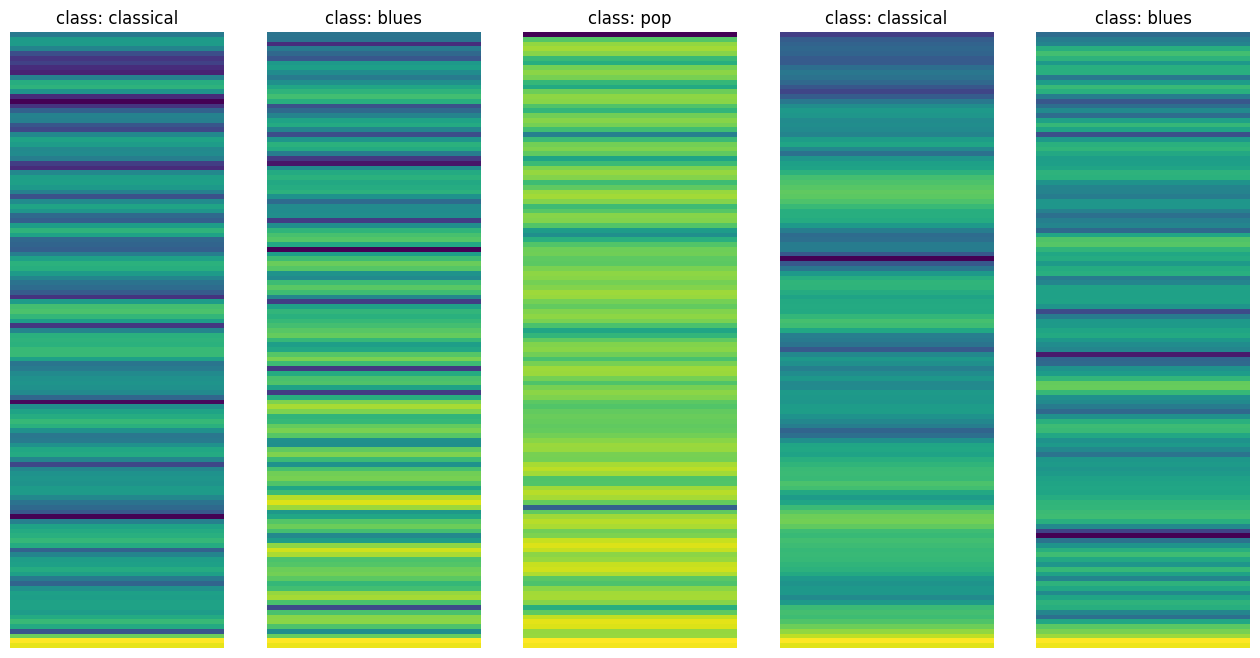

In [9]:
class_names= data.classes
display_random_images(data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

In [10]:
#80% train 20% test split
train, test= random_split(data,[320,80])
train_dataset=train.dataset
test_dataset=test.dataset

In [11]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_dataset, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

In [12]:
class STFTCNNBlock(nn.Module):
    """A single convolutional block for STFT CNN"""
    
    def __init__(self, in_channels: int, out_channels: int, 
                 kernel_size: int, pooling_type: str = 'max'):
        super(STFTCNNBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, 
                             kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        
        if pooling_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:  # average pooling
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [13]:
class STFTCNN(nn.Module):
    """
    CNN for processing STFT features as described in the paper.
    Architecture: 5 convolutional blocks + fully connected layer
    """
    
    def __init__(self, input_channels: int = 1, 
                 conv_configs: Optional[list] = None,
                 num_classes: int = 10, 
                 feature_dim: int = 200):
        """
        Args:
            input_channels: Number of input channels (1 for STFT magnitude)
            conv_configs: List of tuples (out_channels, kernel_size, pooling_type)
                         If None, uses the configuration from Table 1 in the paper
            num_classes: Number of music genres
            feature_dim: Dimension of extracted features (200 as in paper)
        """
        super(STFTCNN, self).__init__()
        
        # Default configuration based on Table 1 (STFT CNN column)
        if conv_configs is None:
            conv_configs = [
                (31, 15, 'max'),      # Conv1: 31 filters, 15x15, MaxPool
                (38, 11, 'max'),      # Conv2: 38 filters, 11x11, MaxPool  
                (43, 9, 'max'),       # Conv3: 43 filters, 9x9, MaxPool
                (57, 6, 'average'),   # Conv4: 57 filters, 6x6, AvgPool
                (64, 3, 'average')    # Conv5: 64 filters, 3x3, AvgPool
            ]
        
        self.conv_blocks = nn.ModuleList()
        in_channels = input_channels
        
        # Create 5 convolutional blocks
        for out_channels, kernel_size, pooling_type in conv_configs:
            block = STFTCNNBlock(in_channels, out_channels, 
                               kernel_size, pooling_type)
            self.conv_blocks.append(block)
            in_channels = out_channels
        
        # Placeholder for adaptive pooling and fully connected layer
        # These will be initialized after the first forward pass
        self.adaptive_pool = None
        self.fc = None
        self.feature_dim = feature_dim
        self.num_classes = num_classes

    def _init_fc_layer(self, x):
        """Initialize the fully connected layer based on feature map size"""
        # Use adaptive average pooling to get fixed size output
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        pooled = self.adaptive_pool(x)
        
        # Calculate flattened feature size
        fc_input_size = pooled.numel() // pooled.shape[0]
        
        # Create fully connected layer for feature extraction
        self.fc = nn.Linear(fc_input_size, self.feature_dim)
        
    def forward(self, x, return_features: bool = False):
        """
        Forward pass through the network
        
        Args:
            x: Input STFT tensor of shape (batch_size, 1, height, width)
            return_features: If True, return features instead of classification
        
        Returns:
            features or logits depending on return_features
        """
        # Pass through convolutional blocks
        for block in self.conv_blocks:
            x = block(x)
        
        # Initialize FC layer on first forward pass
        if self.fc is None:
            self._init_fc_layer(x)
            self.fc = self.fc.to(x.device)
            self.adaptive_pool = self.adaptive_pool.to(x.device)
        
        # Global pooling and flatten
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        
        # Extract features
        features = self.fc(x)
        
        if return_features:
            return features
        else:
            # Add classification layer if needed
            if not hasattr(self, 'classifier'):
                self.classifier = nn.Linear(self.feature_dim, self.num_classes)
                self.classifier = self.classifier.to(features.device)
            
            return self.classifier(features)

In [14]:
model = STFTCNN(input_channels=1, num_classes=4)

In [15]:
tinput, tlabel= next(iter(train_dataloader))

features = model(tinput, return_features=True)
print(f"Feature shape: {features.shape}")

# Forward pass for classification
logits = model(tinput, return_features=False)
print(f"Logits shape: {logits.shape}")

Feature shape: torch.Size([1, 200])
Logits shape: torch.Size([1, 4])


/home/nai/miniconda3/envs/pytorch-music-genre-classifier/lib/python3.13/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


In [16]:
logits

tensor([[ 1.6214,  2.4725, -2.0031,  2.8918]], grad_fn=<AddmmBackward0>)

In [19]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model, input_size=tinput.shape) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
STFTCNN                                  [1, 4]                    --
├─ModuleList: 1-1                        --                        --
│    └─STFTCNNBlock: 2-1                 [1, 31, 64, 646]          --
│    │    └─Conv2d: 3-1                  [1, 31, 129, 1293]        7,006
│    │    └─ReLU: 3-2                    [1, 31, 129, 1293]        --
│    │    └─MaxPool2d: 3-3               [1, 31, 64, 646]          --
│    └─STFTCNNBlock: 2-2                 [1, 38, 32, 323]          --
│    │    └─Conv2d: 3-4                  [1, 38, 64, 646]          142,576
│    │    └─ReLU: 3-5                    [1, 38, 64, 646]          --
│    │    └─MaxPool2d: 3-6               [1, 38, 32, 323]          --
│    └─STFTCNNBlock: 2-3                 [1, 43, 16, 161]          --
│    │    └─Conv2d: 3-7                  [1, 43, 32, 323]          132,397
│    │    └─ReLU: 3-8                    [1, 43, 32, 323]          --
│ 

In [29]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [33]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [34]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [35]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = STFTCNN()

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:13<04:52, 73.17s/it]

Epoch: 1 | train_loss: 1.8207 | train_acc: 0.3950 | test_loss: 0.6031 | test_acc: 0.7650


 40%|████      | 2/5 [02:27<03:41, 73.78s/it]

Epoch: 2 | train_loss: 0.8684 | train_acc: 0.6850 | test_loss: 0.4166 | test_acc: 0.8525


 60%|██████    | 3/5 [03:42<02:28, 74.20s/it]

Epoch: 3 | train_loss: 0.4276 | train_acc: 0.8600 | test_loss: 0.6048 | test_acc: 0.8075


 80%|████████  | 4/5 [04:57<01:14, 74.86s/it]

Epoch: 4 | train_loss: 0.4923 | train_acc: 0.8375 | test_loss: 0.3001 | test_acc: 0.8675


100%|██████████| 5/5 [06:13<00:00, 74.62s/it]

Epoch: 5 | train_loss: 0.2358 | train_acc: 0.9150 | test_loss: 0.3090 | test_acc: 0.8825
Total training time: 373.114 seconds
